In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

In [6]:
df = pd.read_csv("test_scripts/results.csv")
print(df)

def compute_speedup_table(df: pd.DataFrame, col):

    df_speedup = df.copy()
    df_speedup = df_speedup[[ "model", "device", col]]
    # df_latency_speedup.groupby(["model"])

    df_list = []
    for (model,), df_g in df_speedup.groupby(["model"]):
        df_g["speedup"] = df_g[col] / df_g[col].loc[df_g["device"] == "fpga"].values[0]
        df_list.append(df_g)
    df_latency_speedup = pd.concat(df_list)

    return df_latency_speedup

df_speedup_latency = compute_speedup_table(df, "latency (ms)")
df_speedup_edp = compute_speedup_table(df, "EDP (ms-J)")
df_speedup_memory = compute_speedup_table(df, "memory (MB)")

print(df_speedup_latency)
print(df_speedup_edp)
print(df_speedup_memory)

def def_get_speedup(df, model, device):
    return df.loc[(df["model"] == model) & (df["device"] == device)]["speedup"].values[0]

       model device  latency (ms)  memory (MB)  power (W)  energy (mJ)   
0  1st order    cpu        3.3371       7.6328    15.0014      50.0613  \
1  1st order    gpu        2.8040       3.6416    70.2635     197.0215   
2  1st order   fpga        1.8284       0.8547    30.0000      54.8507   
3  2nd order    cpu       12.1731      23.5781    14.8709     181.0254   
4  2nd order    gpu        9.2184      13.0850    74.8821     690.2927   
5  2nd order   fpga        2.5448       7.6707    30.0000      76.3431   

   EDP (ms-J)  
0    0.167059  
1    0.552456  
2    0.100287  
3    2.203641  
4    6.363389  
5    0.194276  
       model device  latency (ms)   speedup
0  1st order    cpu        3.3371  1.825148
1  1st order    gpu        2.8040  1.533581
2  1st order   fpga        1.8284  1.000000
3  2nd order    cpu       12.1731  4.783519
4  2nd order    gpu        9.2184  3.622446
5  2nd order   fpga        2.5448  1.000000
       model device  EDP (ms-J)    speedup
0  1st order    cp

In [7]:
def barplot_annotate_brackets(num1, num2, text, center, height, ax, yerr=None, dh=.05, barh=.05, fs=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param text: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    """

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = ax.get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    # barx = [lx, lx, rx, rx]
    # bary = [y, y+barh, y+barh, y]
    barx = [lx, rx]
    bary = [y+barh, y+barh]

    mid = ((lx+rx)/2, y+barh)

    ax.plot(barx, bary, "-|", c='black', lw=1)

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)

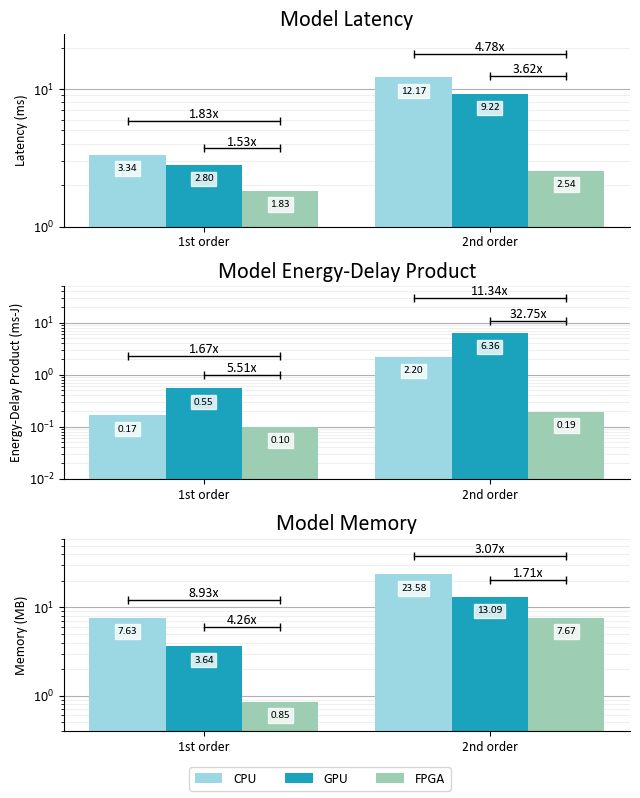

In [12]:
fig, axs = plt.subplots(3,1, figsize=(6.5, 8))

# add fonts from the test_scripts/fonts/ folder
font_dirs = ["test_scripts/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams["font.family"] = "Calibri"


colors=["#90e0ef", "#00b4d8", "#95d5b2"]

# latency
sns.barplot(
    data=df,
    x="model",
    y="latency (ms)",
    hue="device",
    ax=axs[0],
    palette=colors,
)
axs[0].set_title("Model Latency")

# EDP
sns.barplot(
    data=df,
    x="model",
    y="EDP (ms-J)",
    hue="device",
    ax=axs[1],
    palette=colors,
)
axs[1].set_title("Model Energy-Delay Product")

# Memory
sns.barplot(
    data=df,
    x="model",
    y="memory (MB)",
    hue="device",
    ax=axs[2],
    palette=colors,
)
axs[2].set_title("Model Memory")

for ax in axs:
    ax.set_xlabel("")

    ax.grid(axis="y")
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.title.set_fontsize(16)

    ax.get_legend().remove()

    # set the font size for the titles


    # add bar plot values above bars
    for p in ax.patches:
        # white background
        t = ax.annotate(
            format(p.get_height(), ".2f"),
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, -10),
            textcoords="offset points",
            color="black",
            fontsize=8,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.8, edgecolor="white", pad=2))

bars = list(axs[0].patches)
bars.sort(key=lambda bar: bar.get_x())

bars_n = np.arange(len(bars))
heights = [bar.get_height() for bar in bars]
x_locs = [bar.get_x() + bar.get_width() / 2.0 for bar in bars]

# annotate speedup latency
speedup = def_get_speedup(df_speedup_latency, "1st order", "gpu")
barplot_annotate_brackets(1, 2, f"{speedup:.2f}x", x_locs, heights, axs[0], dh=0.02, fs=10)
speedup = def_get_speedup(df_speedup_latency, "1st order", "cpu")
barplot_annotate_brackets(0, 2, f"{speedup:.2f}x", x_locs, heights, axs[0], dh=0.15, fs=10)

speedup = def_get_speedup(df_speedup_latency, "2nd order", "gpu")
barplot_annotate_brackets(4, 5, f"{speedup:.2f}x", x_locs, heights, axs[0], dh=0.2, fs=10)
speedup = def_get_speedup(df_speedup_latency, "2nd order", "cpu")
barplot_annotate_brackets(3, 5, f"{speedup:.2f}x", x_locs, heights, axs[0], dh=0.4, fs=10)

# annotate speedup EDP
speedup = def_get_speedup(df_speedup_edp, "1st order", "gpu")
barplot_annotate_brackets(1, 2, f"{speedup:.2f}x", x_locs, heights, axs[1], dh=-0.32, fs=10)
speedup = def_get_speedup(df_speedup_edp, "1st order", "cpu")
barplot_annotate_brackets(0, 2, f"{speedup:.2f}x", x_locs, heights, axs[1], dh=-0.2, fs=10)

speedup = def_get_speedup(df_speedup_edp, "2nd order", "gpu")
barplot_annotate_brackets(4, 5, f"{speedup:.2f}x", x_locs, heights, axs[1], dh=0.2, fs=10)
speedup = def_get_speedup(df_speedup_edp, "2nd order", "cpu")
barplot_annotate_brackets(3, 5, f"{speedup:.2f}x", x_locs, heights, axs[1], dh=1.5, fs=10)

# annotate speedup memory
speedup = def_get_speedup(df_speedup_memory, "1st order", "gpu")
barplot_annotate_brackets(1, 2, f"{speedup:.2f}x", x_locs, heights, axs[2], dh=0.08, fs=10)
speedup = def_get_speedup(df_speedup_memory, "1st order", "cpu")
barplot_annotate_brackets(0, 2, f"{speedup:.2f}x", x_locs, heights, axs[2], dh=0.3, fs=10)

speedup = def_get_speedup(df_speedup_memory, "2nd order", "gpu")
barplot_annotate_brackets(4, 5, f"{speedup:.2f}x", x_locs, heights, axs[2], dh=0.4, fs=10)
speedup = def_get_speedup(df_speedup_memory, "2nd order", "cpu")
barplot_annotate_brackets(3, 5, f"{speedup:.2f}x", x_locs, heights, axs[2], dh=1, fs=10)

axs[0].set_yscale("log")
axs[0].set_ylim(1E0, 2.5E1)
axs[0].grid(axis="y", which="minor", alpha=0.2)
axs[0].set_ylabel("Latency (ms)")

axs[1].set_yscale("log")
axs[1].set_ylim(1E-2, 5E1)
axs[1].grid(axis="y", which="minor", alpha=0.2)
axs[1].set_ylabel("Energy-Delay Product (ms-J)")

axs[2].set_yscale("log")
axs[2].set_ylim(4E-1, 6E1)
axs[2].grid(axis="y", which="minor", alpha=0.2)
axs[2].set_ylabel("Memory (MB)")

handles, labels = axs[0].get_legend_handles_labels()
labels = ["CPU", "GPU", "FPGA"]
fig.legend(handles, labels, loc="lower center", ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)

plt.show()